<a href="https://colab.research.google.com/github/Riiishaab/OS-Detection-/blob/main/OS_Xception_%26_DenseNet201_%26_MobileNetV2_100_Epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Latest TensorFlow Version

In [ ]:
!pip install --upgrade tensorflow keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 629.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 92.3 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incomp

# Load Dataset and Train-Val-Test Split


In [ ]:
import cv2
import os
import numpy as np
from google.colab import drive
from sklearn.model_selection import train_test_split

# Mount Google Drive
drive.mount('/content/drive')

# Define paths for classes (Normal, Osteopenia, and Osteoporosis)
dataset_paths = {
    'Normal': '/content/drive/MyDrive/OS Dataset/Normal/',
    'Osteopenia': '/content/drive/MyDrive/OS Dataset/Osteopenia/',
    'Osteoporosis': '/content/drive/MyDrive/OS Dataset/Osteoporosis/'
}

# Function to load images and labels
def load_images_and_labels(folder_path, label, target_size=(128, 128)):
    images = []
    labels = []
    for filename in sorted(os.listdir(folder_path)):  # Sort filenames for consistent order
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):  # Check for valid image files
            img_path = os.path.join(folder_path, filename)
            try:
                img = cv2.imread(img_path)  # Load the image
                if img is not None:  # Check if the image is loaded successfully
                    img = cv2.resize(img, target_size)  # Resize the image
                    if len(img.shape) == 2:  # If grayscale, convert to 3-channel
                        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
                    img = img.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
                    images.append(img)  # Add the processed image
                    labels.append(label)  # Add the corresponding label
                else:
                    print(f"Error loading image: {img_path}")  # Print error if image could not be loaded
            except Exception as e:
                print(f"Exception loading image {img_path}: {e}")  # Log any exceptions
        else:
            print(f"Skipping non-image file: {filename}")  # Skip non-image files
    return np.array(images), np.array(labels)

# Load and combine images and labels for all classes
normal_images, normal_labels = load_images_and_labels(dataset_paths['Normal'], label=0)
osteopenia_images, osteopenia_labels = load_images_and_labels(dataset_paths['Osteopenia'], label=1)
osteoporosis_images, osteoporosis_labels = load_images_and_labels(dataset_paths['Osteoporosis'], label=2)

# Combine images and labels from all classes
combined_images = np.concatenate([normal_images, osteopenia_images, osteoporosis_images], axis=0)
combined_labels = np.concatenate([normal_labels, osteopenia_labels, osteoporosis_labels], axis=0)

# Print dataset details
print(f"Normal images: {normal_images.shape[0]}, Osteopenia images: {osteopenia_images.shape[0]}, Osteoporosis images: {osteoporosis_images.shape[0]}")
print(f"Total images: {combined_images.shape[0]}, Total labels: {combined_labels.shape[0]}")

# Shuffle the dataset
indices = np.arange(combined_images.shape[0])  # Generate indices for the dataset
np.random.seed(42)  # Set seed for reproducibility
np.random.shuffle(indices)  # Shuffle the indices
combined_images = combined_images[indices]  # Shuffle images
combined_labels = combined_labels[indices]  # Shuffle corresponding labels

# Final data ready for model input
x_data, y_data = combined_images, combined_labels
print(f"Total images (Check after shuffling): {x_data.shape[0]}")
print(f"Image shape: {x_data.shape[1:]}")
print(f"Labels shape: {y_data.shape}")

# Configurable split ratios
test_ratio = 0.3  # Fraction of the dataset for testing
validation_ratio = 0.1  # Fraction of the training+validation dataset for validation

# Split data into training+validation and test sets
x_train_val, x_test, y_train_val, y_test = train_test_split(
    x_data, y_data, test_size=test_ratio, random_state=42, stratify=y_data)

# Split the training+validation set into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val, test_size=validation_ratio, random_state=42, stratify=y_train_val)

# Print dataset sizes
print(f"Training set: {x_train.shape[0]} samples")
print(f"Validation set: {x_val.shape[0]} samples")
print(f"Test set: {x_test.shape[0]} samples")

# Print class distributions for sanity check
print("Class distribution in Training set:", np.bincount(y_train))
print("Class distribution in Validation set:", np.bincount(y_val))
print("Class distribution in Test set:", np.bincount(y_test))


Mounted at /content/drive
Normal images: 780, Osteopenia images: 374, Osteoporosis images: 793
Total images: 1947, Total labels: 1947
Total images (Check after shuffling): 1947
Image shape: (128, 128, 3)
Labels shape: (1947,)
Training set: 1225 samples
Validation set: 137 samples
Test set: 585 samples
Class distribution in Training set: [491 235 499]
Class distribution in Validation set: [55 26 56]
Class distribution in Test set: [234 113 238]


# Xception

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Define Focal Loss for multi-class classification (with sparse labels)
def focal_loss_multi_class(gamma=2., alpha=None):
    def focal_loss_fixed(y_true, y_pred):
        # One-hot encode y_true
        y_true = K.one_hot(K.cast(y_true, 'int32'), num_classes=3)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())  # Prevent log(0)
        cross_entropy = -y_true * K.log(y_pred)
        if alpha is not None:
            alpha_factor = K.sum(y_true * K.constant(alpha), axis=-1)
            cross_entropy *= alpha_factor
        weight = K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.mean(K.sum(loss, axis=-1))
    return focal_loss_fixed

# Build a Transfer Learning Model using EfficientNetV2B2
def build_model(input_shape, num_classes):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze the last few layers for fine-tuning
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    inputs = layers.Input(shape=input_shape)

    # Pass inputs through the pre-trained model
    x = base_model(inputs, training=False)

    # Global Average Pooling to reduce the feature maps
    x = layers.GlobalAveragePooling2D()(x)

    # Batch Normalization for better training stability
    x = layers.BatchNormalization()(x)

    # Dense layers for multi-class classification
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)  # Regularization

    # Output layer with softmax for multi-class classification
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = models.Model(inputs=inputs, outputs=outputs)

    # Compile the model with Focal Loss
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=focal_loss_multi_class(gamma=2.),
        metrics=['accuracy', 'categorical_accuracy']
    )

    return model

# Define input shape and number of classes
input_shape = (128, 128, 3)
num_classes = 3

# Build and summarize the model
transfer_model = build_model(input_shape, num_classes)
transfer_model.summary()


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 4, 4, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,132,843 (80.62 MB)

 Trainable params: 7,593,387 (28.97 MB)

 Non-trainable params: 13,539,456 (51.65 MB)

In [ ]:

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Print note about the learning rate scheduler
print("Learning Rate Scheduler (ReduceLROnPlateau) is configured.")

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation and test sets
val_test_datagen = ImageDataGenerator()

# Generate augmented training data
train_generator = train_datagen.flow(
    x_train, y_train,
    batch_size=32,
    shuffle=True
)

# Generate validation data
val_generator = val_test_datagen.flow(
    x_val, y_val,
    batch_size=32,
    shuffle=False
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = transfer_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Learning Rate Scheduler (ReduceLROnPlateau) is configured.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 198s 5s/step - accuracy: 0.4529 - categorical_accuracy: 0.3074 - loss: 1.2051 - val_accuracy: 0.5985 - val_categorical_accuracy: 0.2555 - val_loss: 0.3578 - learning_rate: 0.0010
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 184s 5s/step - accuracy: 0.5894 - categorical_accuracy: 0.2070 - loss: 0.6827 - val_accuracy: 0.6423 - val_categorical_accuracy: 0.1752 - val_loss: 0.3856 - learning_rate: 0.0010
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 181s 5s/step - accuracy: 0.6125 - categorical_accuracy: 0.2941 - loss: 0.4865 - val_accuracy: 0.6642 - val_categorical_accuracy: 0.1971 - val_loss: 0.6031 - learning_rate: 0.0010
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 182s 5s/step - accuracy: 0.6375 - categorical_accuracy: 0.2176 - loss: 0.4800 - val_accuracy: 0.6569 - val_categorical_accuracy: 0.1971 - val_loss: 0.6826 - learning_rate: 0.0010
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 182s 5s/step - accuracy: 0.6532 - categorical_accuracy: 0.2219 - loss: 0.3764 - val_accur

# Xception Results

19/19 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step
Test Set Evaluation:
Accuracy: 0.6273504273504273
F1 Score (Weighted): 0.6305750879258324
Cohen's Kappa: 0.42942660796735743
Precision (Weighted): 0.6425518998415739
Recall (Weighted): 0.6273504273504273
Confusion Matrix:
 [[161  20  53]
 [ 21  73  19]
 [ 41  64 133]]


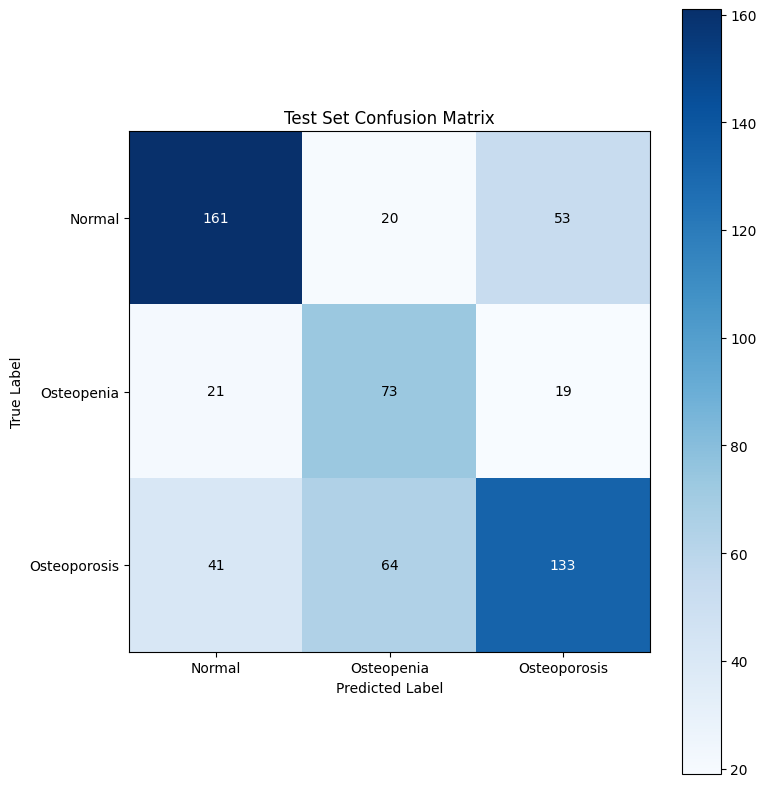

5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step
Validation Set Evaluation:
Accuracy: 0.5985401459854015
F1 Score (Weighted): 0.6034063260340632
Cohen's Kappa: 0.380549161460046
Precision (Weighted): 0.6150206005682285
Recall (Weighted): 0.5985401459854015
Confusion Matrix:
 [[34  6 15]
 [ 3 15  8]
 [10 13 33]]


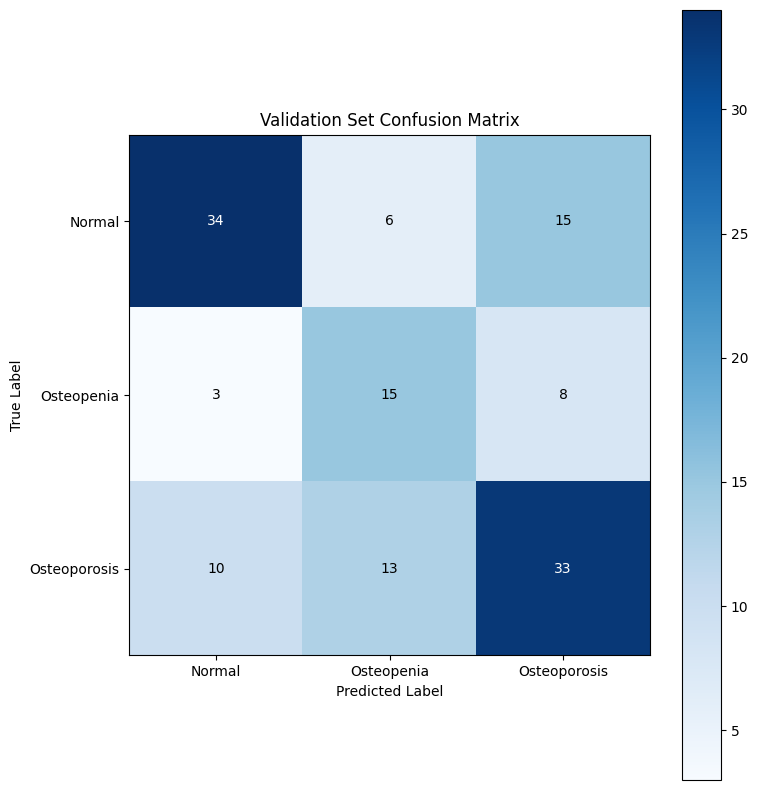

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(y_true, y_pred, num_classes=3):
    """
    Evaluates model predictions using various metrics for multi-class classification.

    Args:
        y_true: Ground truth labels.
        y_pred: Predicted labels.
        num_classes: Number of classes.

    Returns:
        A dictionary containing accuracy, F1 score, Kappa, precision, recall, and confusion matrix.
    """
    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', labels=np.arange(num_classes))
    kappa = cohen_kappa_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', labels=np.arange(num_classes))
    recall = recall_score(y_true, y_pred, average='weighted', labels=np.arange(num_classes))
    cm = confusion_matrix(y_true, y_pred)

    # Display results
    print("Accuracy:", accuracy)
    print("F1 Score (Weighted):", f1)
    print("Cohen's Kappa:", kappa)
    print("Precision (Weighted):", precision)
    print("Recall (Weighted):", recall)
    print("Confusion Matrix:\n", cm)

    # Return metrics
    return {
        "accuracy": accuracy,
        "f1_score": f1,
        "kappa": kappa,
        "precision": precision,
        "recall": recall,
        "confusion_matrix": cm
    }

def plot_confusion_matrix(cm, class_labels, title="Confusion Matrix"):
    """
    Plots a confusion matrix for multi-class classification.

    Args:
        cm: Confusion matrix array.
        class_labels: List of class labels.
        title: Title of the confusion matrix plot.
    """
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.xticks(ticks=np.arange(len(class_labels)), labels=class_labels)
    plt.yticks(ticks=np.arange(len(class_labels)), labels=class_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    # Add counts in the cells
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], "d"),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

# Example usage
# Predict on test set
test_predictions = transfer_model.predict(x_test)  # Predict probabilities
test_pred_labels = np.argmax(test_predictions, axis=-1)  # Convert to multi-class labels

# Evaluate on test set
print("Test Set Evaluation:")
test_metrics = evaluate_model(y_test, test_pred_labels, num_classes=3)

# Plot confusion matrix for the test set
plot_confusion_matrix(test_metrics["confusion_matrix"], class_labels=["Normal", "Osteopenia", "Osteoporosis"], title="Test Set Confusion Matrix")

# Predict on validation set
val_predictions = transfer_model.predict(x_val)  # Predict probabilities
val_pred_labels = np.argmax(val_predictions, axis=-1)  # Convert to multi-class labels

# Evaluate on validation set
print("Validation Set Evaluation:")
val_metrics = evaluate_model(y_val, val_pred_labels, num_classes=3)

# Plot confusion matrix for the validation set
plot_confusion_matrix(val_metrics["confusion_matrix"], class_labels=["Normal", "Osteopenia", "Osteoporosis"], title="Validation Set Confusion Matrix")


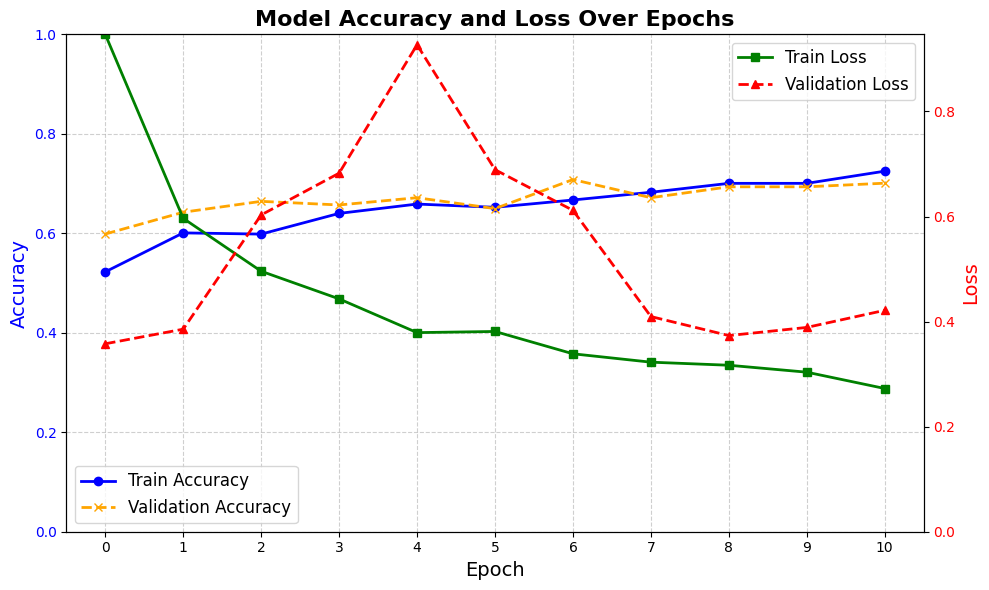

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss values
fig, ax1 = plt.subplots(figsize=(10, 6))  # Create figure and axis

# Plot Accuracy on primary y-axis
ax1.plot(history.history['accuracy'], label='Train Accuracy', color='blue', linestyle='-', marker='o', markersize=6, linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', linestyle='--', marker='x', markersize=6, linewidth=2)

# Set labels for accuracy
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=14, color='blue')
ax1.set_ylim(0, 1)  # Accuracy range from 0 to 1
ax1.tick_params(axis='y', labelcolor='blue')

# Create secondary y-axis for loss
ax2 = ax1.twinx()
if 'loss' in history.history and 'val_loss' in history.history:
    ax2.plot(history.history['loss'], label='Train Loss', color='green', linestyle='-', marker='s', markersize=6, linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--', marker='^', markersize=6, linewidth=2)

# Set labels for loss
ax2.set_ylabel('Loss', fontsize=14, color='red')
ax2.set_ylim(0, max(history.history['loss'] + history.history['val_loss']))  # Set loss axis range based on data
ax2.tick_params(axis='y', labelcolor='red')

# Add title
plt.title('Model Accuracy and Loss Over Epochs', fontsize=16, weight='bold')

# Display grid with lighter style for better visualization
ax1.grid(True, linestyle='--', alpha=0.6)

# Customize x-axis to make it cleaner
plt.xticks(range(0, len(history.history['accuracy']), max(1, len(history.history['accuracy'])//10)), fontsize=12)

# Display legends for both accuracy and loss
ax1.legend(loc='lower left', fontsize=12)
ax2.legend(loc='upper right', fontsize=12)

# Show the plot
plt.tight_layout()  # Adjust layout to avoid clipping of labels
plt.show()


# DenseNet 201

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Define Focal Loss for multi-class classification (with sparse labels)
def focal_loss_multi_class(gamma=2., alpha=None):
    def focal_loss_fixed(y_true, y_pred):
        # One-hot encode y_true
        y_true = K.one_hot(K.cast(y_true, 'int32'), num_classes=3)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())  # Prevent log(0)
        cross_entropy = -y_true * K.log(y_pred)
        if alpha is not None:
            alpha_factor = K.sum(y_true * K.constant(alpha), axis=-1)
            cross_entropy *= alpha_factor
        weight = K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.mean(K.sum(loss, axis=-1))
    return focal_loss_fixed

# Build a Transfer Learning Model using EfficientNetV2B2
def build_model(input_shape, num_classes):
    base_model = DenseNet201(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze the last few layers for fine-tuning
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    inputs = layers.Input(shape=input_shape)

    # Pass inputs through the pre-trained model
    x = base_model(inputs, training=False)

    # Global Average Pooling to reduce the feature maps
    x = layers.GlobalAveragePooling2D()(x)

    # Batch Normalization for better training stability
    x = layers.BatchNormalization()(x)

    # Dense layers for multi-class classification
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)  # Regularization

    # Output layer with softmax for multi-class classification
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = models.Model(inputs=inputs, outputs=outputs)

    # Compile the model with Focal Loss
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=focal_loss_multi_class(gamma=2.),
        metrics=['accuracy', 'categorical_accuracy']
    )

    return model

# Define input shape and number of classes
input_shape = (128, 128, 3)
num_classes = 3

# Build and summarize the model
transfer_model = build_model(input_shape, num_classes)
transfer_model.summary()


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet201 (Functional)             │ (None, 4, 4, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1920)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 1920)                │           7,680 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         245,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,576,451 (70.86 MB)

 Trainable params: 852,291 (3.25 MB)

 Non-trainable params: 17,724,160 (67.61 MB)

In [ ]:

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Print note about the learning rate scheduler
print("Learning Rate Scheduler (ReduceLROnPlateau) is configured.")

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation and test sets
val_test_datagen = ImageDataGenerator()

# Generate augmented training data
train_generator = train_datagen.flow(
    x_train, y_train,
    batch_size=32,
    shuffle=True
)

# Generate validation data
val_generator = val_test_datagen.flow(
    x_val, y_val,
    batch_size=32,
    shuffle=False
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = transfer_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Learning Rate Scheduler (ReduceLROnPlateau) is configured.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 194s 4s/step - accuracy: 0.4851 - categorical_accuracy: 0.2421 - loss: 1.1483 - val_accuracy: 0.6496 - val_categorical_accuracy: 0.1241 - val_loss: 0.8685 - learning_rate: 0.0010
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 165s 4s/step - accuracy: 0.6343 - categorical_accuracy: 0.2607 - loss: 0.7204 - val_accuracy: 0.6861 - val_categorical_accuracy: 0.1387 - val_loss: 0.6233 - learning_rate: 0.0010
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 163s 4s/step - accuracy: 0.6521 - categorical_accuracy: 0.2550 - loss: 0.6195 - val_accuracy: 0.6496 - val_categorical_accuracy: 0.1533 - val_loss: 0.7103 - learning_rate: 0.0010
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 160s 4s/step - accuracy: 0.6637 - categorical_accuracy: 0.2877 - loss: 0.4801 - val_accuracy: 0.6642 - val_categorical_accuracy: 0.1752 - val_loss: 0.5416 - learning_rate: 0.0010
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 163s 4s/step - accuracy: 0.6711 - categorical_accuracy: 0.2595 - loss: 0.5013 - val_accur

# DenseNet 201 Results

19/19 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step
Test Set Evaluation:
Accuracy: 0.7384615384615385
F1 Score (Weighted): 0.7408704780243266
Cohen's Kappa: 0.6025638748523574
Precision (Weighted): 0.7602510340892883
Recall (Weighted): 0.7384615384615385
Confusion Matrix:
 [[176  19  39]
 [  5  99   9]
 [ 28  53 157]]


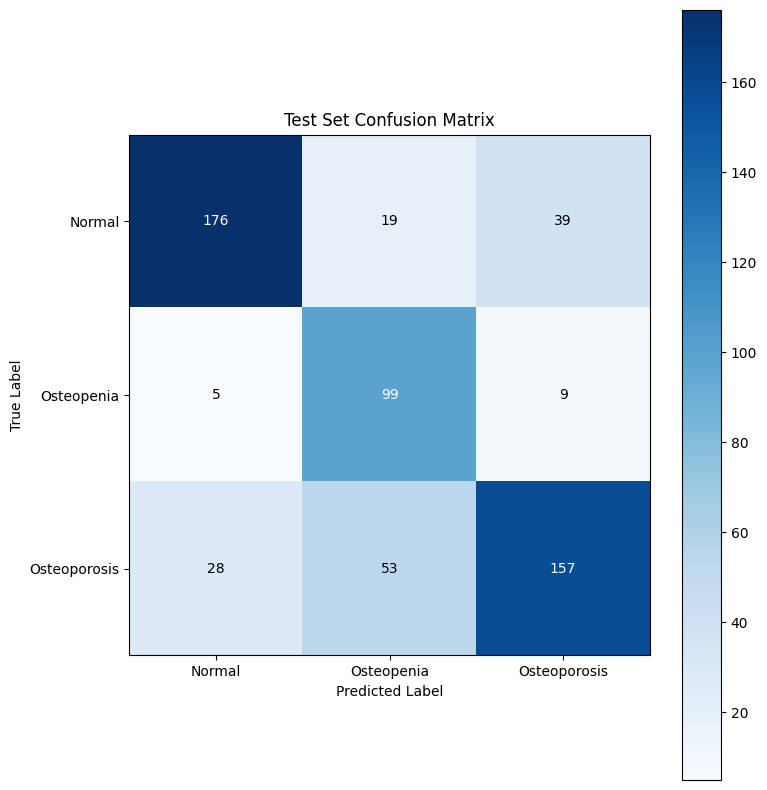

5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step
Validation Set Evaluation:
Accuracy: 0.7591240875912408
F1 Score (Weighted): 0.7644262381262908
Cohen's Kappa: 0.6336007780209092
Precision (Weighted): 0.7940515688690871
Recall (Weighted): 0.7591240875912408
Confusion Matrix:
 [[39  5 11]
 [ 1 23  2]
 [ 2 12 42]]


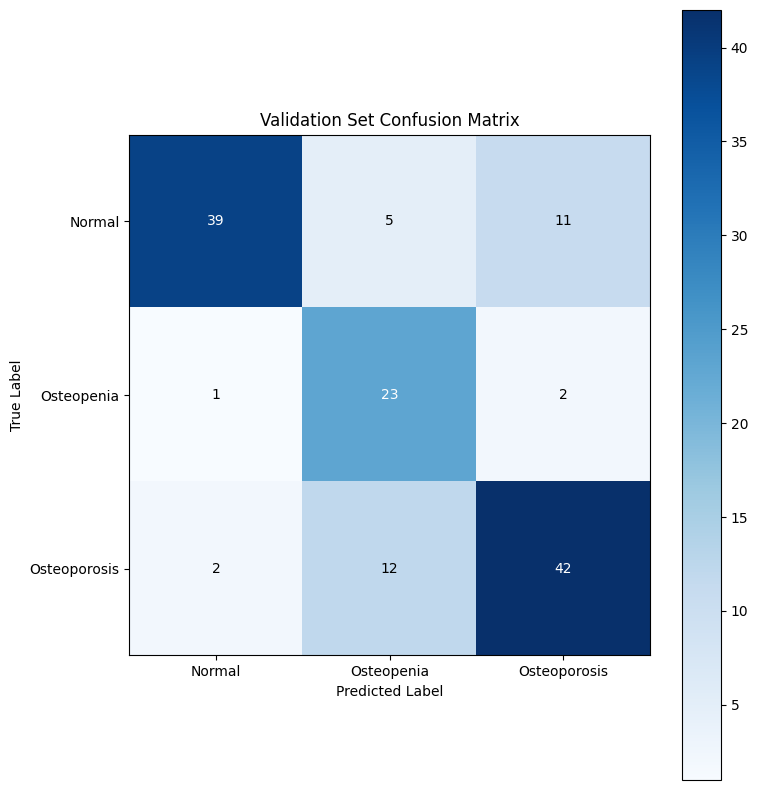

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(y_true, y_pred, num_classes=3):
    """
    Evaluates model predictions using various metrics for multi-class classification.

    Args:
        y_true: Ground truth labels.
        y_pred: Predicted labels.
        num_classes: Number of classes.

    Returns:
        A dictionary containing accuracy, F1 score, Kappa, precision, recall, and confusion matrix.
    """
    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', labels=np.arange(num_classes))
    kappa = cohen_kappa_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', labels=np.arange(num_classes))
    recall = recall_score(y_true, y_pred, average='weighted', labels=np.arange(num_classes))
    cm = confusion_matrix(y_true, y_pred)

    # Display results
    print("Accuracy:", accuracy)
    print("F1 Score (Weighted):", f1)
    print("Cohen's Kappa:", kappa)
    print("Precision (Weighted):", precision)
    print("Recall (Weighted):", recall)
    print("Confusion Matrix:\n", cm)

    # Return metrics
    return {
        "accuracy": accuracy,
        "f1_score": f1,
        "kappa": kappa,
        "precision": precision,
        "recall": recall,
        "confusion_matrix": cm
    }

def plot_confusion_matrix(cm, class_labels, title="Confusion Matrix"):
    """
    Plots a confusion matrix for multi-class classification.

    Args:
        cm: Confusion matrix array.
        class_labels: List of class labels.
        title: Title of the confusion matrix plot.
    """
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.xticks(ticks=np.arange(len(class_labels)), labels=class_labels)
    plt.yticks(ticks=np.arange(len(class_labels)), labels=class_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    # Add counts in the cells
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], "d"),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

# Example usage
# Predict on test set
test_predictions = transfer_model.predict(x_test)  # Predict probabilities
test_pred_labels = np.argmax(test_predictions, axis=-1)  # Convert to multi-class labels

# Evaluate on test set
print("Test Set Evaluation:")
test_metrics = evaluate_model(y_test, test_pred_labels, num_classes=3)

# Plot confusion matrix for the test set
plot_confusion_matrix(test_metrics["confusion_matrix"], class_labels=["Normal", "Osteopenia", "Osteoporosis"], title="Test Set Confusion Matrix")

# Predict on validation set
val_predictions = transfer_model.predict(x_val)  # Predict probabilities
val_pred_labels = np.argmax(val_predictions, axis=-1)  # Convert to multi-class labels

# Evaluate on validation set
print("Validation Set Evaluation:")
val_metrics = evaluate_model(y_val, val_pred_labels, num_classes=3)

# Plot confusion matrix for the validation set
plot_confusion_matrix(val_metrics["confusion_matrix"], class_labels=["Normal", "Osteopenia", "Osteoporosis"], title="Validation Set Confusion Matrix")


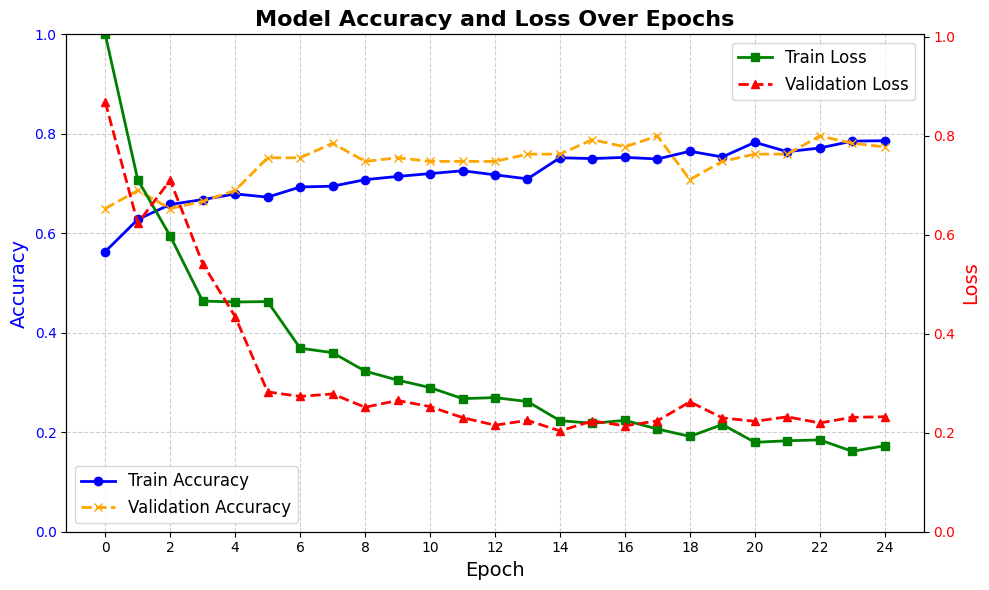

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss values
fig, ax1 = plt.subplots(figsize=(10, 6))  # Create figure and axis

# Plot Accuracy on primary y-axis
ax1.plot(history.history['accuracy'], label='Train Accuracy', color='blue', linestyle='-', marker='o', markersize=6, linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', linestyle='--', marker='x', markersize=6, linewidth=2)

# Set labels for accuracy
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=14, color='blue')
ax1.set_ylim(0, 1)  # Accuracy range from 0 to 1
ax1.tick_params(axis='y', labelcolor='blue')

# Create secondary y-axis for loss
ax2 = ax1.twinx()
if 'loss' in history.history and 'val_loss' in history.history:
    ax2.plot(history.history['loss'], label='Train Loss', color='green', linestyle='-', marker='s', markersize=6, linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--', marker='^', markersize=6, linewidth=2)

# Set labels for loss
ax2.set_ylabel('Loss', fontsize=14, color='red')
ax2.set_ylim(0, max(history.history['loss'] + history.history['val_loss']))  # Set loss axis range based on data
ax2.tick_params(axis='y', labelcolor='red')

# Add title
plt.title('Model Accuracy and Loss Over Epochs', fontsize=16, weight='bold')

# Display grid with lighter style for better visualization
ax1.grid(True, linestyle='--', alpha=0.6)

# Customize x-axis to make it cleaner
plt.xticks(range(0, len(history.history['accuracy']), max(1, len(history.history['accuracy'])//10)), fontsize=12)

# Display legends for both accuracy and loss
ax1.legend(loc='lower left', fontsize=12)
ax2.legend(loc='upper right', fontsize=12)

# Show the plot
plt.tight_layout()  # Adjust layout to avoid clipping of labels
plt.show()


# MobileNet V2

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Define Focal Loss for multi-class classification (with sparse labels)
def focal_loss_multi_class(gamma=2., alpha=None):
    def focal_loss_fixed(y_true, y_pred):
        # One-hot encode y_true
        y_true = K.one_hot(K.cast(y_true, 'int32'), num_classes=3)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())  # Prevent log(0)
        cross_entropy = -y_true * K.log(y_pred)
        if alpha is not None:
            alpha_factor = K.sum(y_true * K.constant(alpha), axis=-1)
            cross_entropy *= alpha_factor
        weight = K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.mean(K.sum(loss, axis=-1))
    return focal_loss_fixed

# Build a Transfer Learning Model using EfficientNetV2B2
def build_model(input_shape, num_classes):
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze the last few layers for fine-tuning
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    inputs = layers.Input(shape=input_shape)

    # Pass inputs through the pre-trained model
    x = base_model(inputs, training=False)

    # Global Average Pooling to reduce the feature maps
    x = layers.GlobalAveragePooling2D()(x)

    # Batch Normalization for better training stability
    x = layers.BatchNormalization()(x)

    # Dense layers for multi-class classification
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)  # Regularization

    # Output layer with softmax for multi-class classification
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = models.Model(inputs=inputs, outputs=outputs)

    # Compile the model with Focal Loss
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=focal_loss_multi_class(gamma=2.),
        metrics=['accuracy', 'categorical_accuracy']
    )

    return model

# Define input shape and number of classes
input_shape = (128, 128, 3)
num_classes = 3

# Build and summarize the model
transfer_model = build_model(input_shape, num_classes)
transfer_model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,427,971 (9.26 MB)

 Trainable params: 1,373,251 (5.24 MB)

 Non-trainable params: 1,054,720 (4.02 MB)

In [ ]:

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Print note about the learning rate scheduler
print("Learning Rate Scheduler (ReduceLROnPlateau) is configured.")

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation and test sets
val_test_datagen = ImageDataGenerator()

# Generate augmented training data
train_generator = train_datagen.flow(
    x_train, y_train,
    batch_size=32,
    shuffle=True
)

# Generate validation data
val_generator = val_test_datagen.flow(
    x_val, y_val,
    batch_size=32,
    shuffle=False
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = transfer_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Learning Rate Scheduler (ReduceLROnPlateau) is configured.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.5137 - categorical_accuracy: 0.2623 - loss: 1.1856 - val_accuracy: 0.6496 - val_categorical_accuracy: 0.1825 - val_loss: 1.5141 - learning_rate: 0.0010
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 37s 939ms/step - accuracy: 0.6659 - categorical_accuracy: 0.3344 - loss: 0.6529 - val_accuracy: 0.5985 - val_categorical_accuracy: 0.1971 - val_loss: 0.8045 - learning_rate: 0.0010
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 34s 873ms/step - accuracy: 0.6325 - categorical_accuracy: 0.2731 - loss: 0.5582 - val_accuracy: 0.6277 - val_categorical_accuracy: 0.1971 - val_loss: 1.1333 - learning_rate: 0.0010
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 34s 860ms/step - accuracy: 0.6686 - categorical_accuracy: 0.2842 - loss: 0.4467 - val_accuracy: 0.6788 - val_categorical_accuracy: 0.1825 - val_loss: 0.6626 - learning_rate: 0.0010
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 33s 851ms/step - accuracy: 0.6862 - categorical_accuracy: 0.2282 - loss: 0.4077 - va

# Results of MobileNet V2

19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 746ms/step
Test Set Evaluation:
Accuracy: 0.7435897435897436
F1 Score (Weighted): 0.7447388444427514
Cohen's Kappa: 0.5977151135337346
Precision (Weighted): 0.746775532093179
Recall (Weighted): 0.7435897435897436
Confusion Matrix:
 [[185   9  40]
 [  1  76  36]
 [ 35  29 174]]


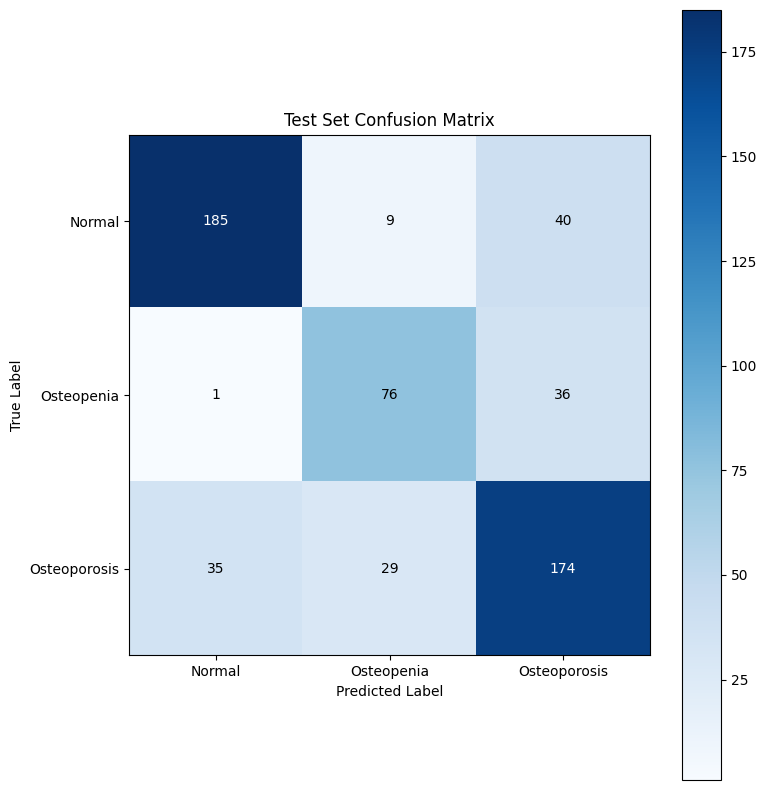

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 604ms/step
Validation Set Evaluation:
Accuracy: 0.7226277372262774
F1 Score (Weighted): 0.7236487802098125
Cohen's Kappa: 0.5635479543930247
Precision (Weighted): 0.726320309145556
Recall (Weighted): 0.7226277372262774
Confusion Matrix:
 [[43  6  6]
 [ 2 13 11]
 [ 6  7 43]]


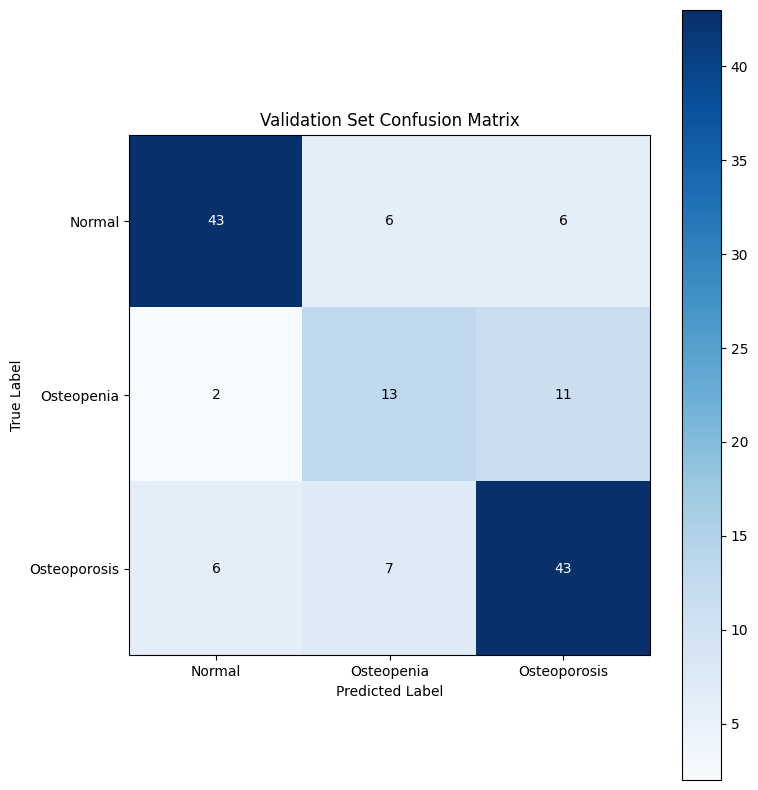

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(y_true, y_pred, num_classes=3):
    """
    Evaluates model predictions using various metrics for multi-class classification.

    Args:
        y_true: Ground truth labels.
        y_pred: Predicted labels.
        num_classes: Number of classes.

    Returns:
        A dictionary containing accuracy, F1 score, Kappa, precision, recall, and confusion matrix.
    """
    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', labels=np.arange(num_classes))
    kappa = cohen_kappa_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', labels=np.arange(num_classes))
    recall = recall_score(y_true, y_pred, average='weighted', labels=np.arange(num_classes))
    cm = confusion_matrix(y_true, y_pred)

    # Display results
    print("Accuracy:", accuracy)
    print("F1 Score (Weighted):", f1)
    print("Cohen's Kappa:", kappa)
    print("Precision (Weighted):", precision)
    print("Recall (Weighted):", recall)
    print("Confusion Matrix:\n", cm)

    # Return metrics
    return {
        "accuracy": accuracy,
        "f1_score": f1,
        "kappa": kappa,
        "precision": precision,
        "recall": recall,
        "confusion_matrix": cm
    }

def plot_confusion_matrix(cm, class_labels, title="Confusion Matrix"):
    """
    Plots a confusion matrix for multi-class classification.

    Args:
        cm: Confusion matrix array.
        class_labels: List of class labels.
        title: Title of the confusion matrix plot.
    """
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.xticks(ticks=np.arange(len(class_labels)), labels=class_labels)
    plt.yticks(ticks=np.arange(len(class_labels)), labels=class_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    # Add counts in the cells
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], "d"),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

# Example usage
# Predict on test set
test_predictions = transfer_model.predict(x_test)  # Predict probabilities
test_pred_labels = np.argmax(test_predictions, axis=-1)  # Convert to multi-class labels

# Evaluate on test set
print("Test Set Evaluation:")
test_metrics = evaluate_model(y_test, test_pred_labels, num_classes=3)

# Plot confusion matrix for the test set
plot_confusion_matrix(test_metrics["confusion_matrix"], class_labels=["Normal", "Osteopenia", "Osteoporosis"], title="Test Set Confusion Matrix")

# Predict on validation set
val_predictions = transfer_model.predict(x_val)  # Predict probabilities
val_pred_labels = np.argmax(val_predictions, axis=-1)  # Convert to multi-class labels

# Evaluate on validation set
print("Validation Set Evaluation:")
val_metrics = evaluate_model(y_val, val_pred_labels, num_classes=3)

# Plot confusion matrix for the validation set
plot_confusion_matrix(val_metrics["confusion_matrix"], class_labels=["Normal", "Osteopenia", "Osteoporosis"], title="Validation Set Confusion Matrix")


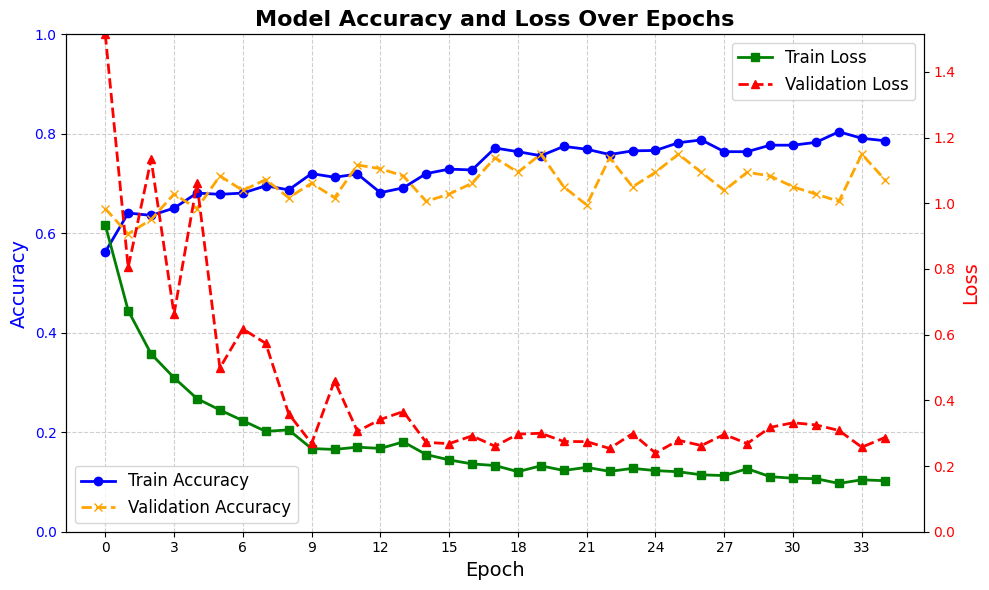

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss values
fig, ax1 = plt.subplots(figsize=(10, 6))  # Create figure and axis

# Plot Accuracy on primary y-axis
ax1.plot(history.history['accuracy'], label='Train Accuracy', color='blue', linestyle='-', marker='o', markersize=6, linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', linestyle='--', marker='x', markersize=6, linewidth=2)

# Set labels for accuracy
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=14, color='blue')
ax1.set_ylim(0, 1)  # Accuracy range from 0 to 1
ax1.tick_params(axis='y', labelcolor='blue')

# Create secondary y-axis for loss
ax2 = ax1.twinx()
if 'loss' in history.history and 'val_loss' in history.history:
    ax2.plot(history.history['loss'], label='Train Loss', color='green', linestyle='-', marker='s', markersize=6, linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--', marker='^', markersize=6, linewidth=2)

# Set labels for loss
ax2.set_ylabel('Loss', fontsize=14, color='red')
ax2.set_ylim(0, max(history.history['loss'] + history.history['val_loss']))  # Set loss axis range based on data
ax2.tick_params(axis='y', labelcolor='red')

# Add title
plt.title('Model Accuracy and Loss Over Epochs', fontsize=16, weight='bold')

# Display grid with lighter style for better visualization
ax1.grid(True, linestyle='--', alpha=0.6)

# Customize x-axis to make it cleaner
plt.xticks(range(0, len(history.history['accuracy']), max(1, len(history.history['accuracy'])//10)), fontsize=12)

# Display legends for both accuracy and loss
ax1.legend(loc='lower left', fontsize=12)
ax2.legend(loc='upper right', fontsize=12)

# Show the plot
plt.tight_layout()  # Adjust layout to avoid clipping of labels
plt.show()
